Check out my model training notebook: https://www.kaggle.com/code/rm1000/holistic-age-prediction-model-selection

Check out my top models notebook: https://www.kaggle.com/code/rm1000/holistic-age-prediction-top-models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
import h5py
import time
import random
import gc
from IPython.display import clear_output

## Loading Data

In [2]:
def load_idmap(idmap_dir):
    idmap = pd.read_csv(idmap_dir, sep=",")
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    sample_type = idmap.sample_type.replace({"control": 0, "disease tissue": 1})
    return age, sample_type

In [3]:
y, sample_type = load_idmap("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/trainmap.csv")
control_ind = pd.DataFrame(sample_type)
control_ind = list(control_ind[control_ind['sample_type']==0].index)
y = y[control_ind]

/tmp/ipykernel_18/2867190384.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample_type = idmap.sample_type.replace({"control": 0, "disease tissue": 1})


In [4]:
X = h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r")["data"][control_ind]
inds = list(range(X.shape[0]))
h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r").close()

In [5]:
rand_train = random.sample(inds, 3000)
X_train,y_train = X[rand_train],y[rand_train]
rand_val = random.sample(list(set(inds)-set(rand_train)), 3000)
X_val,y_val = X[rand_val],y[rand_val]
del X
gc.collect()
clear_output()

## Linear Regression

In [6]:
lr = Ridge(solver="saga",alpha=100,random_state=42,tol=0.01)
lr.fit(X_train,y_train)
mean_absolute_error(lr.predict(X_val),y_val)

5.3686757

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


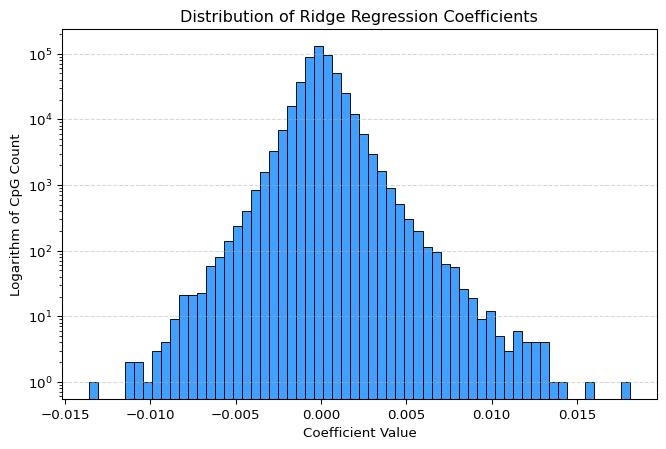

In [7]:
plt.figure(figsize=(8,5), dpi=96)
plt.yscale("log")
sns.histplot(lr.coef_, bins=60, color="#0080ff")
plt.xlabel("Coefficient Value")
plt.ylabel("Logarithm of CpG Count")
plt.title("Distribution of Ridge Regression Coefficients")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

## Feature Selection

In [8]:
coefs = list(lr.coef_)
coefs = [abs(coef) for coef in coefs]
cutoff = round(np.percentile(coefs, 99),5)
print(f"Top 1% cutoff is ±{cutoff}.")

Top 1% cutoff is ±0.00357.


In [9]:
indices = []
for coef,ind in zip(lr.coef_,range(len(lr.coef_))):
    if abs(coef)>cutoff:
        indices.append(ind)
print(f"There were {len(indices)} CpG sites selected.")

There were 4860 CpG sites selected.


In [10]:
X = h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r")["data"][control_ind]
h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r").close()
X = X[:,indices]

## Uploading Data

In [11]:
# h5f = h5py.File('data.h5', 'w')
# h5f.create_dataset('X', data=X)
# h5f.create_dataset('y', data=y)
# h5f.close()